## Feature Engineering
Neste notebook vamos pre-processar os dados e realizar feature engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
import os
import pickle

def performance_metrics(y_pred,y_test):
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_test, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    n = len(y_pred)
    mape = 0
    error = 0 # quando o stock nao teve alteracao e o crescimento foi de 0% descartamos
    for i in range(n):
        if y_test.iloc[i] == 0: # evitar dividir por 0
            error += 1
            continue
        mape += (abs(y_test.iloc[i]-y_pred[i]) / (y_test.iloc[i]))
    mape *= 100/n 

    print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
    print(f"Mean Absolute Error (MAE): {mae:.5f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.5}% - (casos onde y_test=0: {error})")
    return[rmse,mae,mape]


def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
        return to_return
    except:
        print('Fail to load data')
        return None

Dados para treinar e prever se o stock vai subir ou descer do inicio para o final do dia
- ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]

In [2]:
# exemplo de como vai ficar para cada empresa
def feature_eng(df):    
    df.index = pd.to_datetime(df.index)
    df = df[df["ticker"]=="AXON"]

    # o dia da semana
    df['day_of_week'] = df.index.dayofweek  # 0=segunda, 1=terca, ... , 4=sexta
    # para calculos intermedios, no final vamos descartar
    df['close_prev_day'] = df['close'].shift(1)
    df['close_last_week'] = df['close'].shift(5)

    # crescimento do ultimos 3 dias
    df['daily_return_1'] = round((df["close"]-df["open"])/ df["open"],6).shift(1)
    df['daily_return_2'] = round((df["close"]-df["open"])/ df["open"],6).shift(2)
    df['daily_return_3'] = round((df["close"]-df["open"])/ df["open"],6).shift(3)
    # crescimento da ultima semana
    df['weekly_return'] = round((df["close_prev_day"]-df["close_last_week"])/ df["close_last_week"],6)
    # volatilidade do dia anterior
    df['volatility_prev_day'] = round((df['high'] - df['low']) / df['open'],6).shift(1)



    df['target'] = round((df["close"]-df["open"])/ df["open"],6)


    df = df.dropna()
    df = df.drop(['close_prev_day', 'close_last_week'], axis=1)
    return df

In [3]:
df_train = pd.read_csv("dataset_by_sector/train/Industrials.csv", index_col=0)
df_test = pd.read_csv("dataset_by_sector/test/Industrials.csv", index_col=0)
df_train = feature_eng(df_train.copy())
df_test = feature_eng(df_test.copy())

In [4]:
df_test.head()

,open,high,low,close,adjclose,volume,ticker,day_of_week,daily_return_1,daily_return_2,daily_return_3,weekly_return,volatility_prev_day,target
2023-11-01,204.949997,208.190002,203.160004,207.149994,207.149994,344800,AXON,2,0.010726,-0.009136,-0.019152,-0.016260,0.030249,0.010734
2023-11-02,209.770004,212.580002,209.029999,210.270004,210.270004,406400,AXON,3,0.010734,0.010726,-0.009136,0.012612,0.024543,0.002384
2023-11-03,211.970001,219.360001,211.970001,217.250000,217.250000,573800,AXON,4,0.002384,0.010734,0.010726,0.047370,0.016923,0.024909
2023-11-06,219.389999,220.220001,214.830002,216.860001,216.860001,433700,AXON,0,0.024909,0.002384,0.010734,0.076935,0.034863,-0.011532
2023-11-07,216.919998,219.020004,214.699997,216.369995,216.369995,908700,AXON,1,-0.011532,0.024909,0.002384,0.060492,0.024568,-0.002536


## Data Engineering Test

In [5]:
# dividir os dados em treino e teste
X_train = df_train[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3','weekly_return', 'volatility_prev_day']]
y_train = df_train['target']  # target
X_test = df_test[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3','weekly_return', 'volatility_prev_day']]
y_test = df_test['target']  # target

# treinar a random forest regressor
rf = RandomForestRegressor(n_estimators= 500, min_samples_split = 50, random_state=42)
rf.fit(X_train, y_train)

# prever
y_pred = rf.predict(X_test)


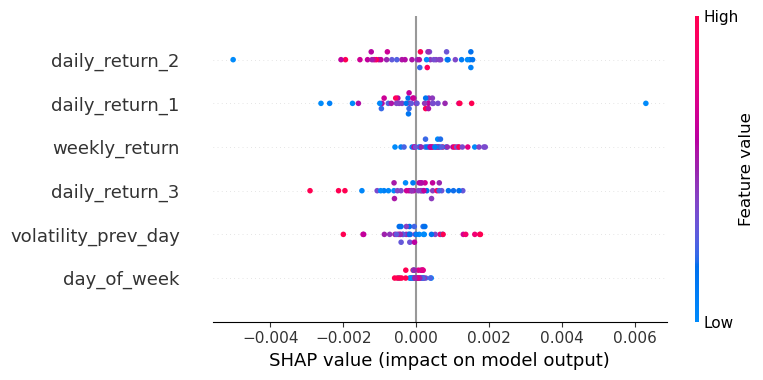

In [6]:
import shap

# Explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Visualize a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# Summary plot for all predictions
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [7]:
shap_values.shape

(41, 6)

In [8]:
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01492
Mean Absolute Error (MAE): 0.01007
Mean Absolute Percentage Error (MAPE): 21.532% - (casos onde y_test=0: 0)


array([0.01986132, 0.22177842, 0.200862  , 0.17047078, 0.16910234,
       0.21792515])

In [9]:
print("Valor de crescimento diário ao longo do mes de novembro e dezembro de 2023\nNo setor 'Consumer_Discretionary' com 30 empresas")
for i in range(len(y_test)):
    print(f"Valor real: {y_test.iloc[i]} | {y_pred[i]:.6f} :Valor previsto ")

Valor de crescimento diário ao longo do mes de novembro e dezembro de 2023
No setor 'Consumer_Discretionary' com 30 empresas
Valor real: 0.010734 | 0.000725 :Valor previsto 
Valor real: 0.002384 | -0.002337 :Valor previsto 
Valor real: 0.024909 | -0.002236 :Valor previsto 
Valor real: -0.011532 | 0.004946 :Valor previsto 
Valor real: -0.002536 | -0.002735 :Valor previsto 
Valor real: 0.022628 | -0.001903 :Valor previsto 
Valor real: -0.063111 | -0.000423 :Valor previsto 
Valor real: 0.008235 | 0.004976 :Valor previsto 
Valor real: 0.001787 | -0.004769 :Valor previsto 
Valor real: 0.000994 | -0.000605 :Valor previsto 
Valor real: -0.004144 | 0.002895 :Valor previsto 
Valor real: 0.003197 | -0.000471 :Valor previsto 
Valor real: -0.006535 | -0.000752 :Valor previsto 
Valor real: 0.008245 | 0.002708 :Valor previsto 
Valor real: 0.010708 | 0.004820 :Valor previsto 
Valor real: -0.006829 | 0.002703 :Valor previsto 
Valor real: 0.005635 | -0.002008 :Valor previsto 
Valor real: 0.003519 | 0.0

In [10]:
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01492
Mean Absolute Error (MAE): 0.01007
Mean Absolute Percentage Error (MAPE): 21.532% - (casos onde y_test=0: 0)


array([0.01986132, 0.22177842, 0.200862  , 0.17047078, 0.16910234,
       0.21792515])

In [11]:
# day_of_week	daily_return_1	daily_return_2	daily_return_3	weekly_return	volatility_prev_day
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01492
Mean Absolute Error (MAE): 0.01007
Mean Absolute Percentage Error (MAPE): 21.532% - (casos onde y_test=0: 0)


array([0.01986132, 0.22177842, 0.200862  , 0.17047078, 0.16910234,
       0.21792515])

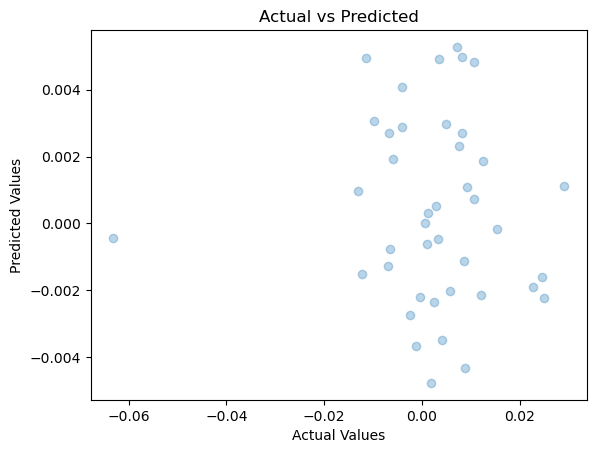

In [12]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


### Função principal para processar por setor

In [13]:
def data_engineering(dataset) -> pd.DataFrame:
    final_df = pd.DataFrame()
    # garantir que index esta como data
    dataset.index = pd.to_datetime(dataset.index)
    
    for company in dataset["ticker"].unique():
        sub_set = dataset[dataset["ticker"] == company].copy()
        
        sub_set['day_of_week'] = sub_set.index.dayofweek  # 0=segunda, 1=terca, ... , 4=sexta
        sub_set['close_prev_day'] = sub_set['close'].shift(1)
        sub_set['close_last_week'] = sub_set['close'].shift(5) # cada semana tem 5 dias de tradding

        # crescimento do ultimos 3 dias
        sub_set['daily_return_1'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6).shift(1)
        sub_set['daily_return_2'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6).shift(2)
        sub_set['daily_return_3'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6).shift(3)
        # crescimento da ultima semana
        sub_set['weekly_return'] = round((sub_set["close_prev_day"]-sub_set["close_last_week"])/ sub_set["close_last_week"],6)
        # volatilidade do dia anterior
        sub_set['volatility_prev_day'] = round((sub_set['high'] - sub_set['low']) / sub_set['open'],6).shift(1)


        ''' 
        # # Calculate 10-day SMA
        # sub_set['SMA_10'] = sub_set['close'].rolling(window=10).mean()

        # # Calculate 10-day EMA
        # sub_set['EMA_10'] = sub_set['close'].ewm(span=10, adjust=False).mean()

        # # RSI Calculation
        # window_length = 14
        # # Calculate daily price changes
        # delta = sub_set['close'].diff()
        # # Separate gains and losses
        # gain = delta.where(delta > 0, 0)
        # loss = -delta.where(delta < 0, 0)
        # # Calculate rolling average gains and losses
        # avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
        # avg_loss = loss.rolling(window=window_length, min_periods=1).mean()
        # # Calculate RS and RSI
        # rs = avg_gain / avg_loss
        # sub_set['RSI'] = 100 - (100 / (1 + rs))


        # fast_ema = sub_set['close'].ewm(span=12, adjust=False).mean()
        # slow_ema = sub_set['close'].ewm(span=26, adjust=False).mean()

        # sub_set['MACD'] = fast_ema - slow_ema
        # sub_set['Signal_Line'] = sub_set['MACD'].ewm(span=9, adjust=False).mean()

        # # Bollinger Bands Calculation
        # window = 20
        # sub_set['SMA_20'] = sub_set['close'].rolling(window=window).mean()
        # sub_set['STD_20'] = sub_set['close'].rolling(window=window).std()

        # sub_set['Upper_Band'] = sub_set['SMA_20'] + (2 * sub_set['STD_20'])
        # sub_set['Lower_Band'] = sub_set['SMA_20'] - (2 * sub_set['STD_20'])
        '''




        sub_set['target'] = round((sub_set["close"]-sub_set["open"])/ sub_set["open"],6)
        
        final_df = pd.concat([final_df,sub_set])
        
    final_df = final_df.dropna()
    final_df = final_df.drop(['close_prev_day', 'close_last_week'], axis=1)
    
    return final_df
       


### Testing performance

Vamos testar a performance em 1 setor para analisar o comportamento das features escolhidas

In [14]:
# dataset- Industrials
df = pd.read_csv("dataset_by_sector/train/Industrials.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [15]:
final = data_engineering(df)
final.head()

,open,high,low,close,adjclose,volume,ticker,day_of_week,daily_return_1,daily_return_2,daily_return_3,weekly_return,volatility_prev_day,target
2020-03-26,14.000000,15.45,14.00,15.45,14.542325,76400,CARR,3,0.139830,-0.093023,-0.094902,0.120833,0.139830,0.103571
2020-03-27,15.000000,16.00,14.55,14.55,13.695203,486500,CARR,4,0.103571,0.139830,-0.093023,0.211765,0.103571,-0.030000
2020-03-30,15.250000,16.50,15.25,15.90,14.965893,210000,CARR,0,-0.030000,0.103571,0.139830,0.260832,0.096667,0.042623
2020-03-31,16.389999,17.25,14.56,17.25,16.236576,461500,CARR,1,0.042623,-0.030000,0.103571,0.358974,0.081967,0.052471
2020-04-01,16.000000,16.00,14.56,15.05,14.165830,2998900,CARR,2,0.052471,0.042623,-0.030000,0.282528,0.164124,-0.059375


In [16]:
df_sorted = final.sort_index()
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74305 entries, 2013-01-09 to 2023-10-31
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   open                 74305 non-null  float64
 1   high                 74305 non-null  float64
 2   low                  74305 non-null  float64
 3   close                74305 non-null  float64
 4   adjclose             74305 non-null  float64
 5   volume               74305 non-null  int64  
 6   ticker               74305 non-null  object 
 7   day_of_week          74305 non-null  int32  
 8   daily_return_1       74305 non-null  float64
 9   daily_return_2       74305 non-null  float64
 10  daily_return_3       74305 non-null  float64
 11  weekly_return        74305 non-null  float64
 12  volatility_prev_day  74305 non-null  float64
 13  target               74305 non-null  float64
dtypes: float64(11), int32(1), int64(1), object(1)
memory usage: 8.2+ MB


In [17]:

# features escolhidas
X = final[["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]]
# X = final[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3',
#        'weekly_return', 'volatility_prev_day', 'SMA_10', 'EMA_10', 'RSI',
#        'MACD', 'Signal_Line', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']]
y = final['target']  # target

# 2/3 treino | 1/3 teste, e mantendo os dados em ordem cronologica
div = 2 * len(final)//3

X_train = X[:div]
X_test = X[div:]
y_train = y[:div]
y_test = y[div:]


# treinar a random forest regressor
rf = RandomForestRegressor(n_estimators=500, min_samples_split=50, random_state=42)
rf.fit(X_train, y_train)

# prever
y_pred = rf.predict(X_test)


In [18]:
# X = final[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3',
#       'weekly_return', 'volatility_prev_day', 'SMA_10', 'EMA_10', 'RSI',
#       'MACD', 'Signal_Line', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01489
Mean Absolute Error (MAE): 0.01035
Mean Absolute Percentage Error (MAPE): -2.8002% - (casos onde y_test=0: 111)


array([0.02041517, 0.1755191 , 0.19183082, 0.19361113, 0.19661715,
       0.22200664])

In [19]:
# X = df_sorted[['day_of_week', 'daily_return_1', 'daily_return_2', 'daily_return_3',
#       'weekly_return', 'volatility_prev_day', 'SMA_10', 'EMA_10', 'RSI',
#       'MACD', 'Signal_Line', 'SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band']]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01489
Mean Absolute Error (MAE): 0.01035
Mean Absolute Percentage Error (MAPE): -2.8002% - (casos onde y_test=0: 111)


array([0.02041517, 0.1755191 , 0.19183082, 0.19361113, 0.19661715,
       0.22200664])

In [20]:
# X = final[["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01489
Mean Absolute Error (MAE): 0.01035
Mean Absolute Percentage Error (MAPE): -2.8002% - (casos onde y_test=0: 111)


array([0.02041517, 0.1755191 , 0.19183082, 0.19361113, 0.19661715,
       0.22200664])

In [21]:
# X = df_sorted[["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]]
performance_metrics(y_pred,y_test)
rf.feature_importances_

Root Mean Squared Error (RMSE): 0.01489
Mean Absolute Error (MAE): 0.01035
Mean Absolute Percentage Error (MAPE): -2.8002% - (casos onde y_test=0: 111)


array([0.02041517, 0.1755191 , 0.19183082, 0.19361113, 0.19661715,
       0.22200664])

<hr>

### Hyper-Parameter Tunning

Especifico para cada setor

Ordem dos setores: 

  0 - 'Consumer_Discretionary'

  1 - 'Energy'

  2 -'Health_Care'

  3 - 'Industrials'
  
  4 - 'Information_Technology'

In [26]:
if not os.path.exists("models_teste2/"):
    os.mkdir("models_teste2/")


path_train = "dataset_by_sector/train/"
train_df = os.listdir(path_train)

path_test = "dataset_by_sector/test/"
test_df = os.listdir(path_test)

metrics = {}

# hyper-parametros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [5, 10, 20, 40],
    'min_samples_leaf': [10, 25, 40],
}


def evaluate_model(params,df_train,df_test):
    predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]
    
    # features and target
    X_train = df_train[predictores]
    y_train = df_train['target']
    
    X_test = df_test[predictores]
    y_test = df_test['target']
    
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    perf = performance_metrics(y_pred, y_test)  # metrica costumizada
    return params, {"rmse": perf[0], "mae": perf[1], "mape":perf[2]}


for i in range(len(test_df)):
    print(f"Setor: {train_df[i].split('.')[0]}")
    
    data_train = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))
    
    # correr a grid search em paralelo, mais rapido
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(evaluate_model)(params,data_train,data_test) for params in ParameterGrid(param_grid)
    )    
    print()
    
    save_pkl(results,f"models_teste2/metrics_{train_df[i].split('.')[0]}.pkl")

Setor: Consumer_Discretionary


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done 128 out of 144 | elapsed: 64.5min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 73.3min finished



Setor: Energy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 128 out of 144 | elapsed: 41.7min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 47.1min finished



Setor: Health_Care


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 48.6min
[Parallel(n_jobs=-1)]: Done 128 out of 144 | elapsed: 57.9min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 65.5min finished



Setor: Industrials


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 128 out of 144 | elapsed: 50.8min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 57.2min finished



Setor: Information_Technology


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 34.3min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 128 out of 144 | elapsed: 59.0min remaining:  7.4min


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 66.8min finished


In [27]:
# visualizar os melhores hiper parametros para cada setor

for metrics_path in os.listdir("models_teste2/"):
    results = load_pkl(f"models_teste2/{metrics_path}")
    # os melhores parametros com base no MAPE
    best_params = None
    best_MAPE = float("inf")  # mais proximo de 0 melhor
    metricas = None


    for params, met in results:
        if abs(met["mape"]) < abs(best_MAPE):
            best_MAPE = met["mape"]
            metricas = met
            best_params = params
    print(f"\n{metrics_path[8:-4]}")
    print("Best Parameters:", best_params)
    print("Metricas:", metricas)


Consumer_Discretionary
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}
Metricas: {'rmse': 0.01371008319699194, 'mae': 0.009763952493713738, 'mape': 9.13841347747135}

Energy
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
Metricas: {'rmse': 0.013585198264575913, 'mae': 0.010068172297086193, 'mape': -1.44113219998669}

Health_Care
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
Metricas: {'rmse': 0.015879342442023783, 'mae': 0.011056790136783162, 'mape': 0.016549183971169664}

Industrials
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}
Metricas: {'rmse': 0.012614807431705628, 'mae': 0.008894834594123031, 'mape': 9.336937393521993}

Information_Technology
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 200}
Metrica

<hr>

### Guardar dados finais e Criar Modelos

- Vamos guardar os datasets finais com os dados gerados

- Com os hyper parametros obtidos vamos agora criar os respetivos modelos para cada setor

In [28]:
if not os.path.exists("models/"):
    os.mkdir("models/")

if not os.path.exists("data/"):
    os.mkdir("data/")
if not os.path.exists("data/train"):
    os.mkdir("data/train")
if not os.path.exists("data/test"):
    os.mkdir("data/test")


params =[{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}, # Consumer_Discretionary
         {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}, # Energy
         {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}, # Health_Care
         {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}, # Industrials
         {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 200}] # Information_Technology

predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]

path_train = "dataset_by_sector/train/"
train_df = os.listdir(path_train)

path_test = "dataset_by_sector/test/"
test_df = os.listdir(path_test)


#### Guadar dados

In [30]:
for i in range(len(test_df)):
    data_train: pd.DataFrame = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))
    
    data_train.to_csv(f"data/train/{train_df[i]}")
    data_test.to_csv(f"data/test/{test_df[i]}")

#### Gerar Modelos

In [31]:
metrics = {}

for i in range(len(test_df)):
    sector = train_df[i].split(".")[0]
    print(f"\nSetor: {sector}")
   
    data_train = data_engineering(pd.read_csv(path_train+train_df[i],index_col=0))
    data_test = data_engineering(pd.read_csv(path_test+test_df[i],index_col=0))

    # features and target
    X_train = data_train[predictores]
    y_train = data_train['target']
    
    X_test = data_test[predictores]
    y_test = data_test['target']
    
    model = RandomForestRegressor(**params[i], random_state=42)
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    perf = performance_metrics(y_pred, y_test)
    metrics[sector] = {"rmse": perf[0], "mae": perf[1], "mape":perf[2]} 
    
    print()
    
    save_pkl(model,f"models_nodeviation/rf_{sector}.pkl")

save_pkl(metrics,f"models_nodeviation/metrics.pkl")



Setor: Consumer_Discretionary
Root Mean Squared Error (RMSE): 0.01371
Mean Absolute Error (MAE): 0.00976
Mean Absolute Percentage Error (MAPE): 9.1384% - (casos onde y_test=0: 1)


Setor: Energy
Root Mean Squared Error (RMSE): 0.01359
Mean Absolute Error (MAE): 0.01007
Mean Absolute Percentage Error (MAPE): -1.4411% - (casos onde y_test=0: 2)


Setor: Health_Care
Root Mean Squared Error (RMSE): 0.01588
Mean Absolute Error (MAE): 0.01106
Mean Absolute Percentage Error (MAPE): 0.016549% - (casos onde y_test=0: 2)


Setor: Industrials
Root Mean Squared Error (RMSE): 0.01261
Mean Absolute Error (MAE): 0.00889
Mean Absolute Percentage Error (MAPE): 9.3369% - (casos onde y_test=0: 6)


Setor: Information_Technology
Root Mean Squared Error (RMSE): 0.01927
Mean Absolute Error (MAE): 0.01310
Mean Absolute Percentage Error (MAPE): 14.379% - (casos onde y_test=0: 2)



In [15]:
# Editar os metadata para identificar o modelo para cada stock, dependendo do seu setor
metadata = pd.read_csv("dataset_by_sector/metadata.csv")
metadata["model"] = metadata["sector"].apply(lambda x: f"models/rf_{x}.pkl")
metadata.to_csv("dataset_by_sector/metadata.csv")

In [26]:
# num de previ corretas sobre a direcao do mercado
previ = [0,0] # [correta,incorreta]

for i in range(len(y_test)):
    
    if (y_test.iloc[i] > 0 and y_pred[i] > 0) or (y_test.iloc[i] < 0 and y_pred[i] < 0): previ[0] += 1
    else: previ[1] += 1
    
previ

[328, 272]

In [19]:
print("Valor de crescimento diario ao longo do mes de jan/2024\nNo setor 'Consumer_Discretionary' com 30 empresas")
for i in range(len(y_test)):
    print(f"Valor real: {y_test.iloc[i]} | {y_pred[i]:.6f} :Valor previsto ")

Valor de crescimento diario ao longo do mes de jan/2024
No setor 'Consumer_Discretionary' com 30 empresas
Valor real: -0.006638 | 0.009637 :Valor previsto 
Valor real: -0.026655 | -0.001941 :Valor previsto 
Valor real: -0.005517 | 0.004371 :Valor previsto 
Valor real: 0.00266 | 0.001820 :Valor previsto 
Valor real: 0.018252 | 0.000810 :Valor previsto 
Valor real: -0.013229 | 0.000154 :Valor previsto 
Valor real: -0.004934 | 0.000134 :Valor previsto 
Valor real: -0.014529 | 0.000484 :Valor previsto 
Valor real: -0.005407 | 0.001121 :Valor previsto 
Valor real: 0.022362 | 0.002117 :Valor previsto 
Valor real: 0.003211 | 0.000702 :Valor previsto 
Valor real: -0.023054 | 0.001006 :Valor previsto 
Valor real: 0.010477 | 0.002622 :Valor previsto 
Valor real: -0.016301 | -0.000862 :Valor previsto 
Valor real: -0.010222 | -0.001600 :Valor previsto 
Valor real: -0.019115 | 0.002219 :Valor previsto 
Valor real: -0.037269 | 0.001001 :Valor previsto 
Valor real: -0.012129 | 0.001675 :Valor previst